In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [4]:
%%writefile practice_work_4.cu
#include <iostream>        // Подключение стандартной библиотеки ввода-вывода
#include <vector>          // Подключение контейнера vector
#include <algorithm>       // Подключение стандартных алгоритмов (например, sort)
#include <cuda_runtime.h>  // Подключение базовых функций CUDA
#include <random>          // Подключение генератора случайных чисел
#include <chrono>          // Подключение инструментов для замера времени
#include <iomanip>         // Подключение манипуляторов форматирования вывода

using namespace std;       // Использование пространства имен std

#define BLOCK_SIZE 256     // Определение размера блока (количество потоков в блоке)

// Макрос для проверки ошибок CUDA при выполнении функций API
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }
// Функция-обработчик ошибок CUDA
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true) {
   if (code != cudaSuccess) {
      // Вывод сообщения об ошибке, имени файла и строки
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code); // Принудительное завершение программы при ошибке
   }
}

// Вспомогательная функция для вывода первых и последних 10 элементов массива
void print_array_bounds(const vector<int>& arr, const string& message) {
    int n = arr.size();                                   // Получение размера массива
    cout << "--- " << message << " ---" << endl;          // Печать заголовка

    cout << "Первые 10: ";                                // Вывод первых 10 элементов
    for (int i = 0; i < min(10, n); i++) cout << arr[i] << " ";

    if (n > 10) {                                         // Если элементов больше 10
        cout << "... ";
        cout << "Последние 10: ";                         // Вывод последних 10 элементов
        for (int i = max(0, n - 10); i < n; i++) cout << arr[i] << " ";
    }
    cout << "\n" << endl;                                 // Перенос строки
}

// ======================================================
// РЕДУКЦИЯ (Параллельное суммирование)
// ======================================================

// Ядро редукции с использованием только глобальной памяти и атомарных операций
__global__ void reduce_global(int* input, unsigned long long* output, int n) {
    // Вычисление глобального индекса потока
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        // Атомарное добавление значения в общую сумму (безопасно для многих потоков)
        atomicAdd(output, (unsigned long long)input[idx]);
    }
}

// Ядро редукции с использованием разделяемой (shared) памяти (более эффективно)
__global__ void reduce_shared(int* input, unsigned long long* output, int n) {
    // Объявление массива в разделяемой памяти для текущего блока
    __shared__ unsigned long long sdata[BLOCK_SIZE];
    unsigned int tid = threadIdx.x;                       // Локальный индекс внутри блока
    unsigned int i = blockIdx.x * blockDim.x + threadIdx.x; // Глобальный индекс

    // Копирование данных из глобальной памяти в быструю разделяемую память
    sdata[tid] = (i < n) ? input[i] : 0;
    __syncthreads();                                      // Барьерная синхронизация всех потоков блока

    // Цикл древовидной редукции внутри блока
    for (unsigned int s = blockDim.x / 2; s > 0; s >>= 1) {
        if (tid < s) {                                    // Если поток в первой половине активного диапазона
            sdata[tid] += sdata[tid + s];                 // Суммируем элементы
        }
        __syncthreads();                                  // Ждем завершения шага всеми потоками блока
    }

    // Первый поток блока записывает итоговую сумму блока в глобальную переменную
    if (tid == 0) atomicAdd(output, sdata[0]);
}

// ======================================================
// СОРТИРОВКА (Odd-Even Bubble Sort внутри блока)
// ======================================================

// Ядро пузырьковой сортировки в разделяемой памяти
__global__ void bubble_sort_shared(int* data, int n) {
    __shared__ int s_data[BLOCK_SIZE];                   // Создаем буфер в быстрой памяти блока
    int tid = threadIdx.x;                                // Индекс внутри блока
    int idx = blockIdx.x * blockDim.x + tid;             // Глобальный индекс

    // Загрузка данных в разделяемую память (заполняем "бесконечностью", если вышли за границы)
    if (idx < n) s_data[tid] = data[idx];
    else s_data[tid] = 2147483647;
    __syncthreads();                                      // Ждем окончания загрузки

    // Выполнение четно-нечетной перестановки BLOCK_SIZE раз
    for (int i = 0; i < BLOCK_SIZE; i++) {
        // Нечетная фаза
        if (tid % 2 == 1 && tid < BLOCK_SIZE - 1) {
            if (s_data[tid] > s_data[tid + 1]) {
                int temp = s_data[tid];
                s_data[tid] = s_data[tid + 1];
                s_data[tid + 1] = temp;
            }
        }
        __syncthreads();                                  // Синхронизация перед следующей фазой

        // Четная фаза
        if (tid % 2 == 0 && tid < BLOCK_SIZE - 1) {
            if (s_data[tid] > s_data[tid + 1]) {
                int temp = s_data[tid];
                s_data[tid] = s_data[tid + 1];
                s_data[tid + 1] = temp;
            }
        }
        __syncthreads();                                  // Синхронизация в конце итерации
    }

    // Записываем локально отсортированные данные обратно в глобальную память
    if (idx < n) data[idx] = s_data[tid];
}

int main() {
    // Список размеров массивов для тестирования
    vector<int> sizes = {10, 100, 1000, 10000, 100000, 1000000};

    random_device rd;                                     // Источник энтропии
    mt19937 gen(rd());                                    // Вихрь Мерсенна (генератор)
    uniform_int_distribution<int> dist(0, 1000000);       // Распределение от 0 до 1 млн

    for (int N : sizes) {                                 // Цикл по всем размерам N
        cout << "==========================================" << endl;
        cout << ">>> Размер массива N = " << N << " <<<" << endl;
        cout << "==========================================" << endl;

        vector<int> h_data(N);                            // Создание массива на CPU (host)
        for (int i = 0; i < N; i++) h_data[i] = dist(gen); // Заполнение случайными числами

        print_array_bounds(h_data, "Исходный массив");    // Печать исходных данных

        int *d_data;                                      // Указатель на данные на GPU (device)
        unsigned long long *d_sum;                        // Указатель на сумму на GPU

        // Выделение памяти на видеокарте
        gpuErrchk(cudaMalloc(&d_data, N * sizeof(int)));
        gpuErrchk(cudaMalloc(&d_sum, sizeof(unsigned long long)));
        // Копирование данных с CPU на GPU
        gpuErrchk(cudaMemcpy(d_data, h_data.data(), N * sizeof(int), cudaMemcpyHostToDevice));

        // Вычисление количества блоков (округление вверх)
        int grid = (N + BLOCK_SIZE - 1) / BLOCK_SIZE;

        cudaEvent_t start, stop;                          // Создание событий для замера времени
        cudaEventCreate(&start); cudaEventCreate(&stop);

        // --- РЕДУКЦИЯ (Тест Global) ---
        cudaMemset(d_sum, 0, sizeof(unsigned long long)); // Обнуление суммы перед запуском
        cudaEventRecord(start);                           // Засекаем время
        reduce_global<<<grid, BLOCK_SIZE>>>(d_data, d_sum, N); // Запуск ядра
        cudaEventRecord(stop);                            // Останавливаем время
        cudaEventSynchronize(stop);                       // Ждем завершения записи события
        float time_g; cudaEventElapsedTime(&time_g, start, stop); // Считаем миллисекунды

        // --- РЕДУКЦИЯ (Тест Shared) ---
        cudaMemset(d_sum, 0, sizeof(unsigned long long)); // Снова обнуляем
        cudaEventRecord(start);                           // Засекаем время
        reduce_shared<<<grid, BLOCK_SIZE>>>(d_data, d_sum, N); // Запуск ядра
        cudaEventRecord(stop);
        cudaEventSynchronize(stop);
        float time_s; cudaEventElapsedTime(&time_s, start, stop);

        cout << "Редукция (Global Memory): " << time_g << " ms\n";
        cout << "Редукция (Shared Memory): " << time_s << " ms\n\n";

        // --- СОРТИРОВКА ---
        cudaEventRecord(start);
        // Запуск локальной сортировки (внутри блоков) на GPU
        bubble_sort_shared<<<grid, BLOCK_SIZE>>>(d_data, N);

        vector<int> h_sorted(N);                          // Буфер для результата на CPU
        // Копируем частично отсортированные данные обратно
        gpuErrchk(cudaMemcpy(h_sorted.data(), d_data, N * sizeof(int), cudaMemcpyDeviceToHost));

        // Финальная досортировка на CPU (т.к. GPU сортировал только внутри независимых блоков)
        sort(h_sorted.begin(), h_sorted.end());

        cudaEventRecord(stop);
        cudaEventSynchronize(stop);
        float time_sort; cudaEventElapsedTime(&time_sort, start, stop);

        print_array_bounds(h_sorted, "Отсортированный массив"); // Вывод результата

        cout << "Сортировка (GPU + Final Merge): " << time_sort << " ms\n";

        // Проверка корректности (идет ли массив по возрастанию)
        bool correct = true;
        for(int i = 1; i < N; i++) if(h_sorted[i-1] > h_sorted[i]) correct = false;
        cout << "Результат: " << (correct ? "Массив успешно отсортирован" : "Ошибка сортировки") << "\n\n";

        // Освобождение выделенной памяти на GPU
        gpuErrchk(cudaFree(d_data));
        gpuErrchk(cudaFree(d_sum));
        // Удаление событий
        cudaEventDestroy(start);
        cudaEventDestroy(stop);
    }

    return 0; // Завершение программы
}

Overwriting practice_work_4.cu


In [5]:
!nvcc practice_work_4.cu -o practice_work_4
!./practice_work_4

>>> Размер массива N = 10 <<<
--- Исходный массив ---
Первые 10: 178509 14859 459772 889944 837535 441778 751122 84183 97849 159722 

Редукция (Global Memory): 8.55504 ms
Редукция (Shared Memory): 0.003392 ms

--- Отсортированный массив ---
Первые 10: 14859 84183 97849 159722 178509 441778 459772 751122 837535 889944 

Сортировка (GPU + Final Merge): 0.026752 ms
Результат: Массив успешно отсортирован

>>> Размер массива N = 100 <<<
--- Исходный массив ---
Первые 10: 516340 950707 699838 311940 414535 580509 817578 770707 122067 701621 ... Последние 10: 617844 405136 5825 514941 59439 924339 17722 355307 976610 827881 

Редукция (Global Memory): 0.004128 ms
Редукция (Shared Memory): 0.003328 ms

--- Отсортированный массив ---
Первые 10: 1644 1704 5825 14444 17722 20228 25187 29095 59439 63310 ... Последние 10: 942731 946583 950707 953899 958810 968775 969723 976610 982755 999674 

Сортировка (GPU + Final Merge): 0.041056 ms
Результат: Массив успешно отсортирован

>>> Размер массива N = 

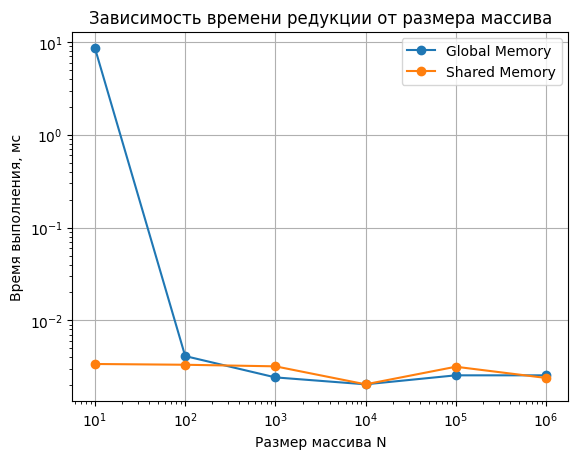

In [6]:
import matplotlib.pyplot as plt

# Размеры массивов
N = [10, 100, 1000, 10000, 100000, 1000000]

# Время редукции (мс)
time_global = [8.55504, 0.004128, 0.002432, 0.002048, 0.00256, 0.00256]
time_shared = [0.003392, 0.003328, 0.0032, 0.002048, 0.003168, 0.0024]

plt.figure()
plt.plot(N, time_global, marker='o', label='Global Memory')
plt.plot(N, time_shared, marker='o', label='Shared Memory')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Размер массива N')
plt.ylabel('Время выполнения, мс')
plt.title('Зависимость времени редукции от размера массива')
plt.legend()
plt.grid(True)

plt.show()

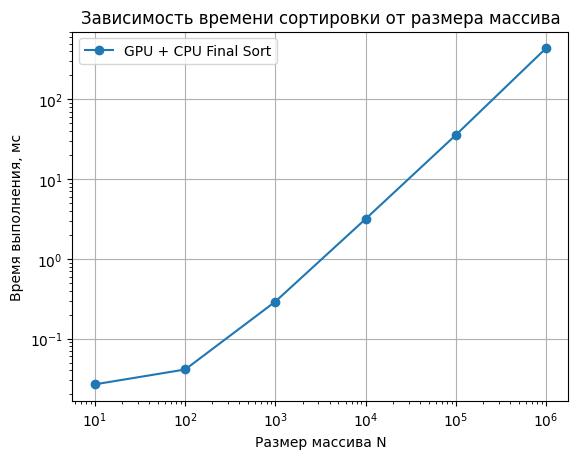

In [7]:
import matplotlib.pyplot as plt

# Размеры массивов
N = [10, 100, 1000, 10000, 100000, 1000000]

# Время сортировки (мс)
time_sort = [0.026752, 0.041056, 0.291648, 3.16317, 35.689, 436.635]

plt.figure()
plt.plot(N, time_sort, marker='o', label='GPU + CPU Final Sort')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Размер массива N')
plt.ylabel('Время выполнения, мс')
plt.title('Зависимость времени сортировки от размера массива')
plt.legend()
plt.grid(True)

plt.show()